In [1]:
%matplotlib inline
import yt 
import numpy as np
import matplotlib.pyplot as plt

from yt.visualization.base_plot_types import get_multi_plot
import matplotlib.colorbar as cb
from matplotlib.colors import LogNorm


from galaxy_analysis.yt_fields import field_generators as fg
from galaxy_analysis.utilities import convert_abundances as ca
from galaxy_analysis.utilities import utilities as galutil
from galaxy_analysis.plot.plot_styles import *

from galaxy_analysis import particle_analysis as pa

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

rc('text',usetex=False)
rc('font',size=fsize)


In [2]:
#
# Check out the WD particles
#

def check_SNIa_properties(data):
    pt = data['particle_type']
    select = pt >= 11
    
    pt = pt[select]
    m  = data['particle_mass'][select].to('Msun')
    WD_select = pt == 12
    
    
    #
    # Check to make sure no particles that are SNIa
    # get double assigned SNIa types 
    #

    num_doubled = 0
    nsnia = 0

    for i in np.arange(np.size(pt)):
        num_neg = 0

        if (data['snia_metal_fraction'][select][i] < 0):
            num_neg += 1
        if (data['snia_sch_metal_fraction'][select][i] < 0):
            num_neg += 1
        if (data['snia_sds_metal_fraction'][select][i] < 0):
            num_neg += 1
        if (data['snia_hers_metal_fraction'][select][i] < 0):
            num_neg += 1

        if num_neg == 1:
            nsnia += 1
        elif num_neg > 1:
            num_doubled += 1
            
            print(data['birth_mass'][select][i], data['creation_time'][select][i].to('Myr'), pt[i])
            for f in ['snia_metal_fraction','snia_sch_metal_fraction','snia_sds_metal_fraction','snia_hers_metal_fraction']:
                print(" %5.5E"%(data[f][select][i]),end = " ")
            
            print("doubled up on particle",i,num_neg)    
    

    complete_SNIa = (pt==12)*(m==0.0)

    n_part = np.size(pt)


    ideal = {'DDS' : 0.05126958193824957,'SDS': 0.005242912915506227, 'sCh' :0.09073471211157359,
               'HeRS' : 0.0035997607307840106, 'total' : 0.15084696769611342}


    print("Number of particles ", n_part)
    print("Number of WD particles ", np.size(pt[WD_select]))
    print("Number of particles that will (or have) gone SNIa ", nsnia)
    print("Number of particles that have double (or more) assigned SNIa properties ", num_doubled)
    print("Number of particles that have gone SNIa ", np.size(pt[complete_SNIa]))

    sntypes = ['DDS','sCh','SDS','HeRS']
    #
    # Count the types
    #
    #
    num_snia = {}
    data_field = {'DDS' : 'snia_metal_fraction', 'sCh' : 'snia_sch_metal_fraction',
                  'SDS' : 'snia_sds_metal_fraction', 'HeRS' : 'snia_hers_metal_fraction'}
    for sntype in sntypes:
        select2 = (data[ data_field[sntype] ] < 0 ) * select

        num_snia[sntype] = np.size(pt[select2])


    print("Fraction of SNIa Types")
    total_num = 0
    for sntype in sntypes:
        total_num += num_snia[sntype]
        print("%10s: Number = %4i  - Fraction = %.5f - Target Fraction %.5f"%(sntype, num_snia[sntype], num_snia[sntype]/(1.0*n_part), ideal[sntype]))

    print("%10s: Number = %4i - Fraction = %.5f - Target Fraction %.5f"%("Total", total_num, total_num/(1.0*n_part), ideal['total']))
    


In [3]:
workdir = "/home/aemerick/work/enzo_runs/ISC/2pc_NoPISN/"
workdir = "/home/aemerick/work/enzo_runs/BoG/"
#workdir = "/home/aemerick/work/enzo_runs/cosmo_testing/local/"

In [4]:
dsname = "DD0017"
dsname = dsname + '/' + dsname

dsname = "DD0017/output_0017"

ds = yt.load(workdir + dsname)
if not 'output' in dsname:
    fg.generate_derived_fields(ds)
    ds = yt.load(workdir + dsname)
    fg.generate_particle_filters(ds)
    data = ds.all_data()
else:
    data = ds.all_data()

In [7]:
def popIII_threshold(C_f, Fe_f, H_f, return_value = False):
    """
    Apply the Chiaki+2017 popIII to popII transition star threshold.
    Returns True if above this threshold (popII SF) and False if below
    (popIII).
    
    Using same hard-coded constants as Enzo
    
    If return_value is true, returns the value of 10**([C/H]-2.3) + 10**([Fe/H])
    """
    
    threshold = 10.0**(-5.07)
    
    H_abund  = H_f  / 1.00790
    C_abund  = C_f  / 12.0107
    Fe_abund = Fe_f / 55.8450
    
    C_H_solar = 8.43 - 12.0
    Fe_H_solar = 7.50 - 12.0
    
    C_over_H  = np.log10( C_abund / H_abund) - C_H_solar
    Fe_over_H = np.log10( Fe_abund / H_abund) - Fe_H_solar
    
    local_C_Fe = 10.0**(C_over_H-2.3) + 10.0**(Fe_over_H)
    
    if return_value:
        return local_C_Fe
    else:
        return local_C_Fe >= threshold

def popIII_selection(ds, data, subselection = None):
    """
    Returns a selection function for which stars are PopIII from all data
    """
    
    if subselection is None:
        subselection = data['metallicity_fraction'] == data['metallicity_fraction']
    
    if ds.parameters['PopIIIMetalCriticalFraction'] > 0:
        select = data['metallicity_fraction'][subselection] < ds.parameters['PopIIIMetalCriticalFraction']
    
    elif ds.parameters['PopIIIMetalCriticalFraction'] < 0:
        
        C_f  = data[('io','particle_C_fraction')][subselection]
        Fe_f = data[('io','particle_Fe_fraction')][subselection]
        H_f  = data[('io','particle_H_fraction')][subselection]
    
        select = np.logical_not(popIII_threshold(C_f, Fe_f, H_f))
        
    else:
        print("Do not understand PopIIIMetalCriticalFraction value")
        raise ValueError
    
    pt_selection = data['particle_type'][subselection] >= 11
    
    return select * pt_selection

def popII_selection(ds, data, subselection = None):
   
    if subselection is None:
        subselection = data['metallicity_fraction'] == data['metallicity_fraction']
        
    popII_and_DM = np.logical_not(popIII_selection(ds,data,subselection))
    
    popII = popII_and_DM * (data['particle_type'][subselection]>=11)
    
    return popII
    

In [11]:
#
# Gather some information
# 11: PopII individual star
# 12: WD
# 13: Remnant
# 14: PopIII
# 15: Unresolved (PopII?)

ds.print_stats()

print("Current Redshift = %6.2f"%(ds.current_redshift))
print("Current Time     = %6.3f Myr"%(ds.current_time.to('Myr')))
print("Min / max resolution:   %6.3f / %6.3f pccm"%(np.min(dx),np.max(dx)))

pm = data['particle_mass'].to('Msun')
bm = data['birth_mass']
dx = data['dx'].to('pccm')
pt = data['particle_type']
Z  = data['metallicity_fraction']

t_form = data['creation_time'].to('Myr')

star_select   = (pt>=11)
popII_select  = popII_selection(ds, data)
popIII_select = popIII_selection(ds,data)

possible_rproc_select  = (pt>=11) * (bm > ds.parameters['IndividualStarRProcessMinMass']) *\
                                    (bm < ds.parameters['IndividualStarRProcessMaxMass']) * popII_select
rproc_select           = (pt==13) * (bm > ds.parameters['IndividualStarRProcessMinMass']) *\
                                    (bm < ds.parameters['IndividualStarRProcessMaxMass']) * popII_select


possible_agb_select    = (pt>=11) * (bm > 3.0) * (bm < 8.0) * popII_select
finished_agb_select    = (pt>=12) * (pt<=13)   * (bm > 3.0) * (bm < 8.0)


print("Number of Stars: %6.3E"%(np.size(bm[star_select])))
print("Number of PopII Stars ever formed  : %6.3E"%(np.size(bm[popII_select])))
print("Number of PopIII Stars ever formed : %6.3E"%(np.size(bm[popIII_select])))

print("Total Stellar Mass (ever): %6.3E"%(np.sum(bm[star_select])))
print("Total PopII Stellar Mass (ever): %6.3E"%(np.sum(bm[popII_select])))
print("Total PopIII Stellar Mass (ever): %6.3E"%(np.sum(bm[popIII_select])))



print("Total number of eventual AGB stars (ever): %6.3E"%(np.size(bm[possible_agb_select])))
print("Total number of AGB stars (ever): %6.3E"%(np.size(bm[finished_agb_select])))

print("Total number of stars in R-Process mass range (ever): %6.3E"%(np.size(bm[possible_rproc_select])))
print("Total number of stars in R-Process mass range that have exploded: %6.3E"%(np.size(bm[rproc_select])))


print("-----------Star Types-----------")
print("type number BM PM")
for i in [11,12,13,14,15]:
    if len(bm[pt==i]) > 0:
        print("%04i %5i %5.3E %5.3E %5.3E %5.3E %5.3E %5.3E"%(i, np.size(bm[pt==i]), np.sum(bm[pt==i]), np.min(bm[pt==i]), np.max(bm[pt==i]),
                                                             np.sum(pm[pt==i]), np.min(pm[pt==i]), np.max(pm[pt==i])))
    else:
        print("%04i %5i None None None None None None"%(i,0))

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	   512	      16777216	           256
  1	  5195	      44875896	           356
  2	  2081	       4015360	           159
  3	   757	       1008144	           101
  4	   272	        190392	            58
  5	    98	         36680	            34
  6	     6	          6272	            19
  7	     2	          2240	            14
  8	     1	          3136	            15
  9	     1	          2800	            15
----------------------------------------------
   	  8925	      66918136


t = 1.58550638e+01 = 7.32607996e+15 s = 2.32149465e+08 years

Smallest Cell:
	Width: 4.227e-07 Mpc
	Width: 4.227e-01 pc
	Width: 8.719e+04 AU
	Width: 1.304e+18 cm
Current Redshift =  17.05
Current Time     = 232.149 Myr


NameError: name 'dx' is not defined

In [ ]:
subselection = data['particle_type'] >= 11

chiaki = popIII_threshold(data[('io','particle_C_fraction')][subselection],
                 data[('io','particle_Fe_fraction')][subselection],
                 data[('io','particle_H_fraction')][subselection],return_value=True)


print("Treshold = %6.3E"%(10.0**(-5.07)))
for pval in [11,12,13,14,15]:
    
    select = (pt[subselection] == pval)
    
    if np.size(pt[subselection][select]) > 0:
        minval = np.min(chiaki[select])
        maxval = np.max(chiaki[select])
    else:
        minval = 0
        maxval = 0

    
    print("ParticleType: %i   Chiaki min: %6.3E  Chiaki Max: %6.3E"%(pval,minval,maxval))
    
    
chiaki_gas = popIII_threshold( data['C_Fraction'], data['Fe_Fraction'], data['H_fraction'], return_value=True)

for ncut in [0, 1.0E-3, 0.1, 1.0, 10.0, 100.0]:
    select = data['number_density'] > ncut
    
    if np.size(chiaki_gas[select]) > 0:
        print("n > %.4f:  %6.3E  %6.3E   %6.3E"%(ncut, np.min(chiaki_gas[select]),np.max(chiaki_gas[select]), np.median(chiaki_gas[select])))
    else:
        print("n > %.4f: None None None"%(ncut))

In [12]:
select = (chiaki_gas > 10.0**(-5.07)) * (chiaki_gas < 10.0**(-4.0))

ztemp = data['metallicity'][select]
print(np.min(ztemp), np.max(ztemp))

8.388847671494573e-10 Zsun 0.01807565596447252 Zsun


In [62]:
dxmin = np.min(data['dx'].to('pc')) / 4.0 / 2.0 /2.0 /2.0 /2.0

print(dxmin)

0.05002441729592233 pc


In [63]:
dx_cm = np.min(data['dx'].to('pccm')) / 4.0 / 2.0 /2.0 /2.0 /2.0

dx_cm * (1.0 + 0.0) / (1.0 + ds.current_redshift)

0.05002441729592234 pccm

In [64]:
#
# if I want 1 pc
#
z_p, dx_p = (0.0, 1.0)  # current
z_p_new, dx_p_new = (7.0, 0.5) # new target

dx_cm = dx_p * (1.0 + z_p) / (1.0 + 0.0) # 
print("Old co-moving", dx_cm)
dx_cm_new = dx_p_new * (1.0 + z_p_new) / (1.0 + 0.0) # 
print("New co-moving", dx_cm_new)

print("z    dx_p_old    dx_p_new    ratio")
for z in [20,17.5,15,12.5,11,10,9,8,7]:
    dx_p_z = dx_p * (1.0+z_p)/(1.0+z)  
    dx_p_new = 0.5 * (1.0+7.0)/(1.0+z) # new target
    print("%5.2f   %4.3f       %4.3f       %4.3f"%(z, dx_p_z, dx_p_new, dx_p_new / dx_p_z))

Old co-moving 1.0
New co-moving 4.0
z    dx_p_old    dx_p_new    ratio
20.00   0.048       0.190       4.000
17.50   0.054       0.216       4.000
15.00   0.062       0.250       4.000
12.50   0.074       0.296       4.000
11.00   0.083       0.333       4.000
10.00   0.091       0.364       4.000
 9.00   0.100       0.400       4.000
 8.00   0.111       0.444       4.000
 7.00   0.125       0.500       4.000


In [12]:
field_units  =  {'Density' : 'g/cm**3',
                 'x_velocity' : 'km/s',
                 'y_velocity' : 'km/s','z_velocity':'km/s','vx' : 'km/s',
                 "Temperature" : 'K', 'creation_time' : 'Myr', 'dynamical_time' : 'Myr'}


In [13]:

print("%20s - %20s:    %5s   %5s   %5s"%("Type 0","Field","Sum","Min","Max"))
for field in ds.field_list:

    if field[0] != 'enzo':
        continue
    
    vals = data[field]

    if np.size(vals) > 0:
        if field[1] in field_units:
            vals = vals.to(field_units[field[1]])
        elif 'kph' in field[1]:
            vals = vals.to('1/s')
        elif '_Density' in field[1]:
            try:
                vals = vals.to('g/cm**3')
            except:
                vals = vals

        print("%6s - %20s:    %5.3E   %5.3E  %5.3E"%(field[0],field[1], np.sum(vals), np.min(vals), np.max(vals)))
    else:
        print("%6s - %20s:    None    None    None"%(field[0],field[1]))
  



              Type 0 -                Field:      Sum     Min     Max
  enzo -  Dark_Matter_Density:    1.889E-17   0.000E+00  1.254E-18
  enzo -              Density:    1.138E-17   1.480E-29  2.388E-20
  enzo -     Electron_Density:    3.061E-20   5.815E-32  1.346E-22
  enzo -            GasEnergy:    5.550E+02   2.254E-07  9.049E-01
  enzo -         H2II_Density:    4.845E-27   1.118E-42  7.203E-29
  enzo -          H2I_Density:    1.103E-21   5.457E-44  4.163E-24
  enzo -            H2I_kdiss:    3.571E+10   1.112E+00  2.547E+07
  enzo -          HII_Density:    3.021E-20   5.815E-32  1.346E-22
  enzo -           HI_Density:    8.619E-18   1.118E-36  1.815E-20
  enzo -               HI_kph:    1.301E-05   0.000E+00  3.133E-06
  enzo -           HM_Density:    5.188E-27   5.067E-43  8.358E-29
  enzo -        HeIII_Density:    1.713E-24   5.585E-49  4.998E-26
  enzo -         HeII_Density:    1.589E-21   3.786E-42  8.036E-24
  enzo -          HeI_Density:    2.730E-18   1.409E-39  5.

In [15]:
print("=================================== Particles ==============================================")
particle_fields = [x for x in ds.field_list if x[0] == 'io']
pt = data['particle_type']
for ptnum in [11,12,13,14,15]:
    select = pt==ptnum
    print("----------- Particle Type %i -------------"%(ptnum))

    for field in particle_fields:
        vals = data[field][select]

        if np.size(vals) > 0:
            if field[1] in field_units:
                vals = vals.to(field_units[field[1]])
            elif 'kph' in field[1]:
                vals = vals.to('1/s')
            elif '_Density' in field[1]:
                try:
                    vals = vals.to('g/cm**3')
                except:
                    vals = vals

            print("%6s - %30s:    %5.3E   %5.3E  %5.3E"%(field[0],field[1], np.sum(vals), np.min(vals), np.max(vals)))
        else:
            print("%6s - %30s:    None    None    None"%(field[0],field[1]))    


=================================== Particles ==============================================
----------- Particle Type 11 -------------
    io -                  creation_time:    None    None    None
    io -                 dynamical_time:    None    None    None
    io -           metallicity_fraction:    None    None    None
    io -                 particle_index:    None    None    None
    io -                  particle_mass:    None    None    None
    io -            particle_position_x:    None    None    None
    io -            particle_position_y:    None    None    None
    io -            particle_position_z:    None    None    None
    io -                  particle_type:    None    None    None
    io -            particle_velocity_x:    None    None    None
    io -            particle_velocity_y:    None    None    None
    io -            particle_velocity_z:    None    None    None
----------- Particle Type 12 -------------
    io -                  creation_time: 

In [17]:
ds.derived_field_list

[('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('al

Parsing Hierarchy : 100%|██████████| 8925/8925 [00:00<00:00, 11880.67it/s]


Total Mass Above SF Treshold = 5.129E+04 Msun



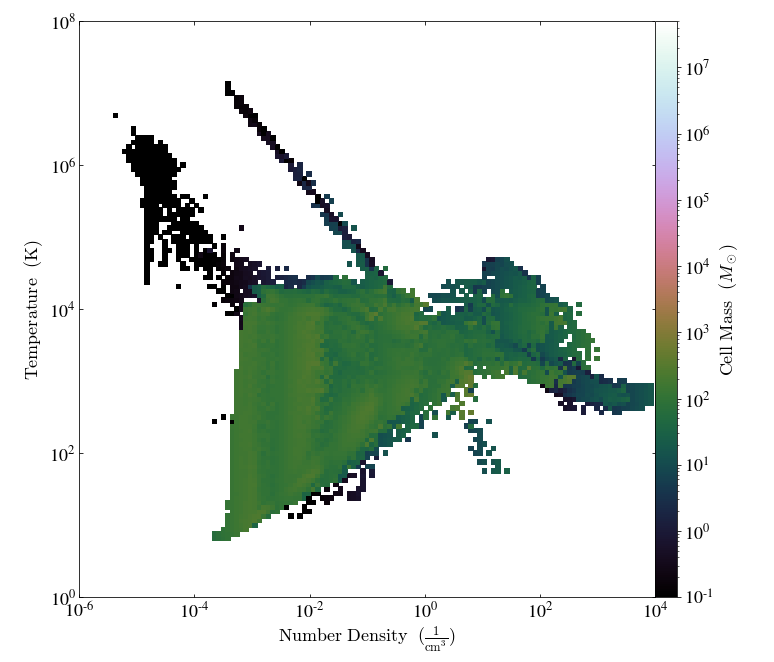

['/home/aemerick/work/enzo_runs/BoG/output_0017_2d-Profile_number_density_Temperature_cell_mass.png']

In [5]:
#
#
# Projection Plot(s)
#
#
plot_settings()

pp = yt.PhasePlot(ds, 'number_density','Temperature', 'cell_mass')

pp.set_unit('number_density','1/cm**3')
pp.set_unit('Temperature','K')
pp.set_xlim(1.0E-6,1.0E4)
pp.set_ylim(1.0,1.0E8)

pp.set_unit("cell_mass","Msun")
pp.set_zlim('cell_mass',0.1,5.0E7)
pp.set_cmap('cell_mass','cubehelix')

n  = data['number_density']
cm = data['cell_mass'].to('Msun')

print("Total Mass Above SF Treshold = %5.3E Msun"%(np.sum(cm[n>ds.parameters['StarMakerOverDensityThreshold']])))

pp.show()
pp.save(workdir)



In [14]:
#
#
# Full-box SFR
# 
#


popIII_select = ((pt == 13)* (data[('io','metallicity_fraction')] < ds.parameters['PopIIIMetalCriticalFraction'])) + (pt==14)
select        = (pt >= 11 ) * (data[('io','metallicity_fraction')] > ds.parameters['PopIIIMetalCriticalFraction'])
                 
t_o = 0.0*yt.units.Myr
dt  = 100.0*yt.units.Myr

t, total_sfr = pa.sfrFromParticles(ds,data, times = dt, t_o =t_o, selection = (pt>=11))
t, sfr_popII = pa.sfrFromParticles(ds,data, times = dt, t_o =t_o,selection=select)
t, sfr_popIII = pa.sfrFromParticles(ds,data, times = dt, t_o =t_o,selection=popIII_select)   

dt  = 10.0*yt.units.Myr
times = np.arange(0.0,np.max(t.to('Myr'))+dt,10.0) * yt.units.Myr

t_H, total_sfh = pa.sfhFromParticles(ds,data, times = times, selection = (pt>=11))
t_H, sfh_popII = pa.sfhFromParticles(ds,data, times = times, selection=select)
t_H, sfh_popIII = pa.sfhFromParticles(ds,data, times = times, selection=popIII_select)   

t =t.to('Myr')
t_H = t_H.to('Myr')


In [24]:
t_H

YTArray([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
         110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
         220., 230., 240., 250., 260., 270., 280., 290., 300.]) Myr

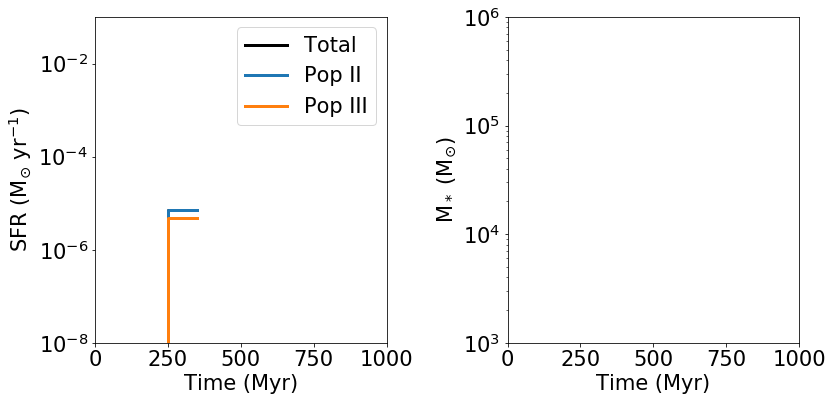

In [15]:
plot_settings()

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

t_norm = t-t[0]

t_norm = 0.5*(t_norm[1:]+t_norm[:-1])

ax[0].step(t_norm, total_sfr, lw = 3, color = 'black', label = 'Total',where='pre')
ax[0].step(t_norm, sfr_popII, lw = 3, color = 'C0', label = 'Pop II',where='pre')
ax[0].step(t_norm, sfr_popIII, lw = 3, color = 'C1', label = 'Pop III',where='pre')

t_norm = t_H-t_H[0]

ax[1].plot(t_norm, total_sfh, lw = 3, color = 'black', label = 'Total')
ax[1].plot(t_norm, sfh_popII, lw = 3, color = 'C0', label = 'Pop II')
ax[1].plot(t_norm, sfh_popIII, lw = 3, color = 'C1', label = 'Pop III')

for a in ax:
    a.set_xlim(0.0,1000.0)
    a.semilogy()
    a.set_xlabel(r"Time (Myr)")
    
ax[0].set_ylim(1.0E-8,0.1)
ax[1].set_ylim(1000.0,1.0E6)


ax[0].set_ylabel(r"SFR (M$_{\odot}$ yr$^{-1}$)")
ax[1].set_ylabel(r"M$_*$ (M$_{\odot}$)")

ax[0].legend(loc='best')
plt.tight_layout()

plotting :  0 0 H_p0_fraction
plotting :  0 1 H_p1_fraction
plotting :  0 2 He_p0_fraction
plotting :  1 0 He_p1_fraction
plotting :  1 1 He_p2_fraction
plotting :  1 2 H2_p0_fraction
plotting :  2 0 H2_p1_fraction
plotting :  2 1 H_m1_fraction


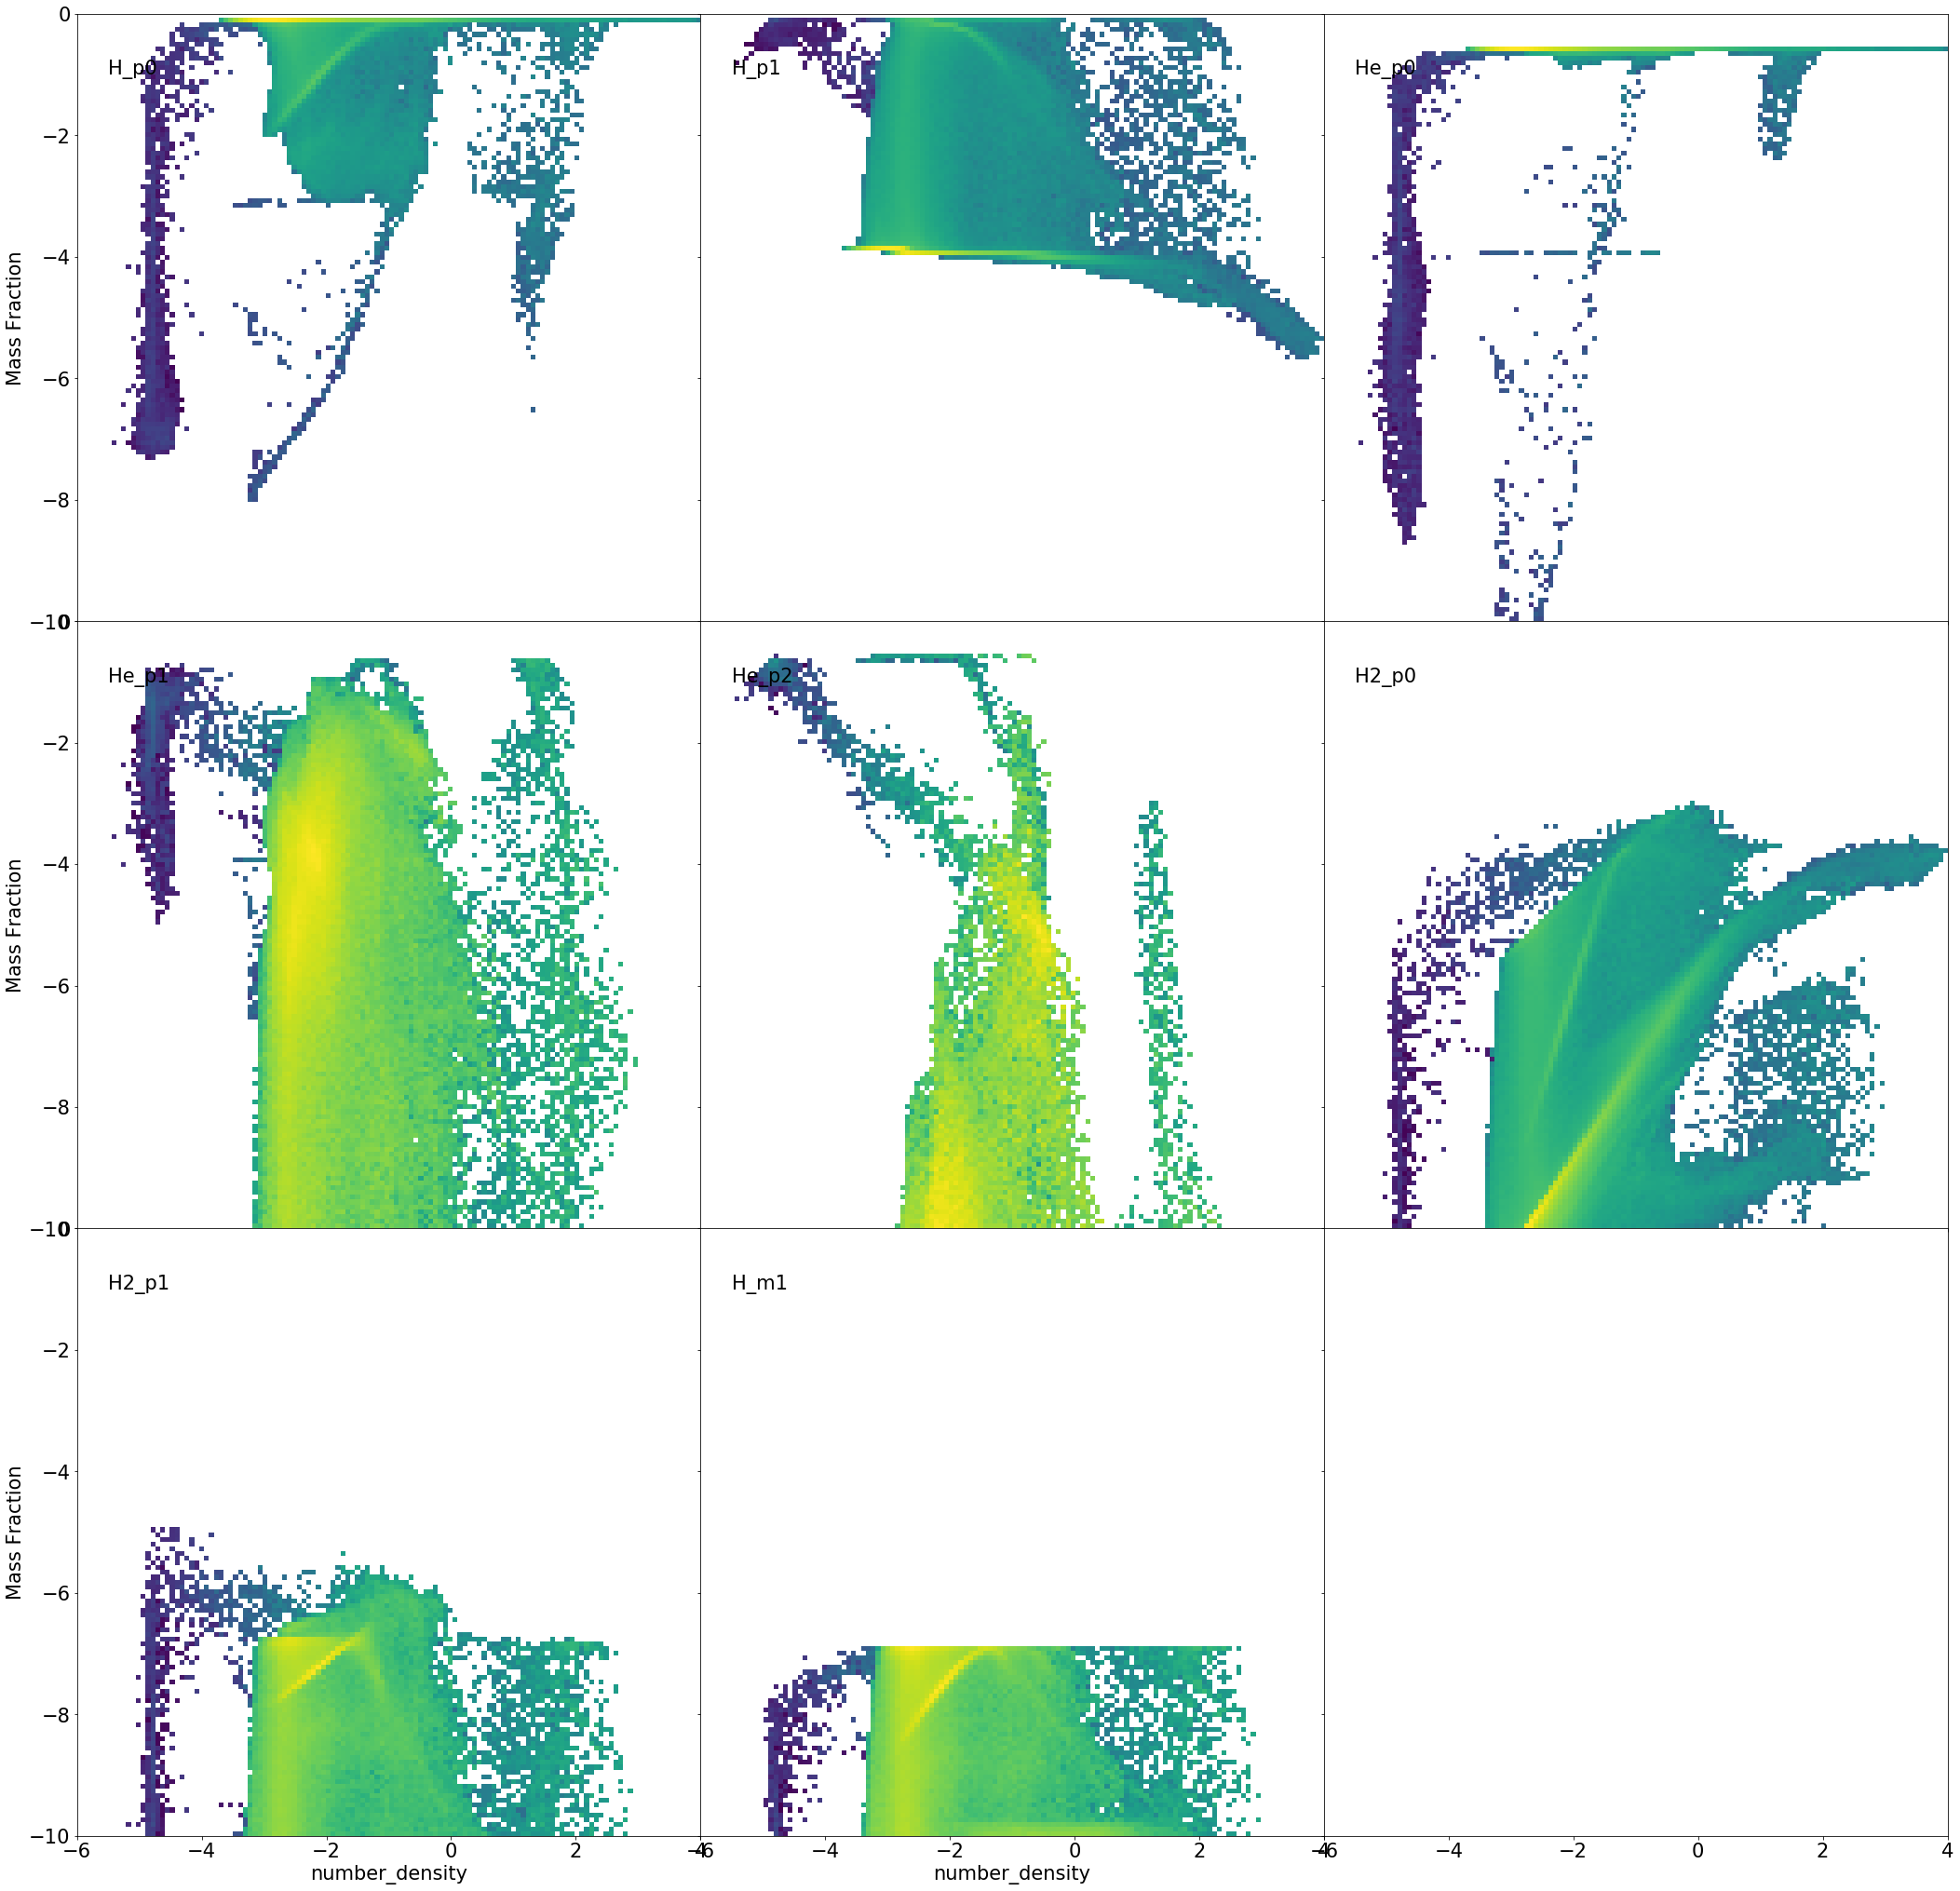

In [6]:
    species = ['H_p0','H_p1','He_p0','He_p1','He_p2',
           'H2_p0','H2_p1','H_m1']

    plot_settings()
    
    extrema = {'number_density' : (1.0E-6,1.0E4)}
    logs    = {'number_density' : True}
    
    units = {('gas','cell_mass') : 'Msun'}
    
    for s in species:
        extrema[s + '_fraction'] = (1.0E-10,1.0)
        logs[s + '_fraction']    = True
    
    fs = 12
    nrow = 3
    ncol = 3
    fig, ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    
    fig.subplots_adjust(wspace=0,hspace=0)
    
    xfield = 'number_density'
    zfield = ('gas','cell_mass')
    
    if np.size(xfield) > 1:
        xfield_label = xfield[1]
    elif '_over_' in xfield:
        xfield_label = "[X/" + denom_element + "]"
    else:
        xfield_label = xfield    
    
    axi = 0
    axj = 0
    if len(species) > nrow*ncol:
        print("Not enough rows and columns for all species")
        print(species)
        print(nrow*ncol)
        raise RuntimeError
        
    for s in species:
        axindex = (axi,axj)
        
        yfield = s + '_fraction'
        
        yfield_label = 'Mass Fraction'
        
        print("plotting : ",axi,axj, yfield)
        prof = yt.create_profile(ds.all_data(), [xfield, yfield],
                      n_bins=[128,128], fields=[zfield],
                      logs={xfield:logs[xfield], yfield:logs[yfield]},                             
                      extrema={xfield:extrema[xfield],yfield:extrema[yfield]},
                      weight_field=None)    
    
        xvals = prof.x.value
        yvals = prof.y.value
        zvals = prof.field_data[zfield].to( units[zfield] ).value
        
        if logs[xfield]:
            xextent = np.log10( extrema[xfield])
        else:
            xextent = 1.0 * np.array(extrema[xfield])
            
        if logs[yfield]:
            yextent = np.log10( extrema[yfield])
        else:
            yextent = 1.0 * np.array(extrema[yfield])
                
        
        ax[axindex].imshow(zvals.T, origin='lower', norm = LogNorm(), aspect='auto',
                                    extent  = (xextent[0],xextent[1],yextent[0],yextent[1]))
        
        xytext = (0.05,0.9)
        ax[axindex].annotate(s,
                             xy=xytext, xycoords='axes fraction',
                             xytext=xytext, textcoords='axes fraction'
                             ) 
        
        if axj == 0:
            ax[axindex].set_ylabel(yfield_label)
            
        if axi == nrow - 1:
            ax[axindex].set_xlabel(xfield_label)
    
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1

    fig.savefig(workdir + dsname.split('/')[0] + '_species_mass_fractions_phase_panel.png')
    
     

In [ ]:
plot_settings()


    
def plot_species_panel(_ds, species = None, denom_element='H'):

    if species is None:
        species = galutil.species_from_fields(ds.field_list)

    extrema = {'number_density' : (1.0E-6,1.0E4)}
    logs    = {'number_density' : True}
    
    units = {('gas','cell_mass') : 'Msun'}
    
             
    for s in species:
        extrema[s + '_over_H']  = (-8,2)
        extrema[s + '_over_Fe'] = (-5,5)
        extrema[s + '_over_Mg'] = (-5,5)
        extrema[s + '_over_Ba'] = (-5,5)
        
        logs[s+'_over_'+denom_element]=False
    
    fs = 12
    nrow = 3
    ncol = 3
    fig, ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
    fig.set_size_inches(fs*ncol,fs*nrow)
    
    fig.subplots_adjust(wspace=0,hspace=0)
    
    xfield = 'number_density'
    zfield = ('gas','cell_mass')
    
    if np.size(xfield) > 1:
        xfield_label = xfield[1]
    elif '_over_' in xfield:
        xfield_label = "[X/" + denom_element + "]"
    else:
        xfield_label = xfield    
    
    axi = 0
    axj = 0
    if len(species) > nrow*ncol:
        print("Not enough rows and columns for all species")
        print(species)
        print(nrow*ncol)
        raise RuntimeError
        
    elif len(species) < nrow*ncol:
        # just to get looping to work out OK
        
        species = species + [denom_element]*(nrow*ncol - len(species))
        
    for s in species:
        axindex = (axi,axj)
  
        yfield = s + '_over_' + denom_element

        if np.size(yfield) > 1:
            yfield_label = yfield[1]
        elif '_over_' in yfield:
            yfield_label = "[X/" + denom_element + "]"
        else:
            yfield_label = yfield

        if s != denom_element:        


            print("plotting : ",axi,axj, yfield)
            prof = yt.create_profile(_ds.all_data(), [xfield, yfield],
                          n_bins=[128,128], fields=[zfield],
                          logs={xfield:logs[xfield], yfield:logs[yfield]},                             
                          extrema={xfield:extrema[xfield],yfield:extrema[yfield]},
                          weight_field=None)    

            xvals = prof.x.value
            yvals = prof.y.value
            zvals = prof.field_data[zfield].to( units[zfield] ).value

            if logs[xfield]:
                xextent = np.log10( extrema[xfield])
            else:
                xextent = 1.0 * np.array(extrema[xfield])

            if logs[yfield]:
                yextent = np.log10( extrema[yfield])
            else:
                yextent = 1.0 * np.array(extrema[yfield])


            ax[axindex].imshow(zvals.T, origin='lower', norm = LogNorm(), aspect='auto',
                                        extent  = (xextent[0],xextent[1],yextent[0],yextent[1]))

            xytext = (0.05,0.9)
            ax[axindex].annotate(s,
                                 xy=xytext, xycoords='axes fraction',
                                 xytext=xytext, textcoords='axes fraction'
                                 ) 
        
        if axj == 0:
            ax[axindex].set_ylabel(yfield_label)
            
        if axi == nrow - 1:
            ax[axindex].set_xlabel(xfield_label)
    
        axj = axj + 1
        if axj >= 3:
            axj = 0
            axi = axi + 1

    fig.savefig(workdir + dsname.split('/')[0] + '_X_over_' + denom_element + '_phase_panel.png')
    
    return
    
plot_species_panel(ds,denom_element='Mg')
plot_species_panel(ds,denom_element='Fe')
plot_species_panel(ds,denom_element='Ba')

plot_species_panel(ds)


plotting :  0 0 C_over_Mg
plotting :  0 1 N_over_Mg
plotting :  0 2 O_over_Mg
plotting :  1 1 Ca_over_Mg
plotting :  1 2 Fe_over_Mg
plotting :  2 0 Sr_over_Mg
plotting :  2 1 Ba_over_Mg
plotting :  0 0 C_over_Fe
plotting :  0 1 N_over_Fe
plotting :  0 2 O_over_Fe
plotting :  1 0 Mg_over_Fe
plotting :  1 1 Ca_over_Fe
plotting :  2 0 Sr_over_Fe
plotting :  2 1 Ba_over_Fe
plotting :  0 0 C_over_Ba
plotting :  0 1 N_over_Ba
plotting :  0 2 O_over_Ba
plotting :  1 0 Mg_over_Ba
plotting :  1 1 Ca_over_Ba
plotting :  1 2 Fe_over_Ba
plotting :  2 0 Sr_over_Ba
plotting :  0 0 C_over_H


In [68]:
np.size("hello")

1

In [84]:
center = ds.domain_center.to('kpc')
l      = 0.5*ds.domain_width[0]

In [26]:
fields = ['number_density','PhotoGamma','Pe_heating_rate_masked']
center = ds.domain_center.to('kpc')
center = center + np.array([0.0,2.5,-1.5])*yt.units.kpc

region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(ds, 'x', fields, weight_field = 'Metal_Density', center = center,
                       data_source=region, width = 0.75*l)

pp.set_zlim('Pe_heating_rate_masked',1.0E-40,1.0E-30)
pp.show()

sp = yt.SlicePlot(ds,'x',fields,center=center,data_source=region,width=0.75*l)
sp.show()

NameError: name 'l' is not defined

/home/aemerick/.local/lib/python3.7/site-packages/yt/data_objects/construction_data_containers.py:379: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(nvals, nwvals[:,None], nvals)
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



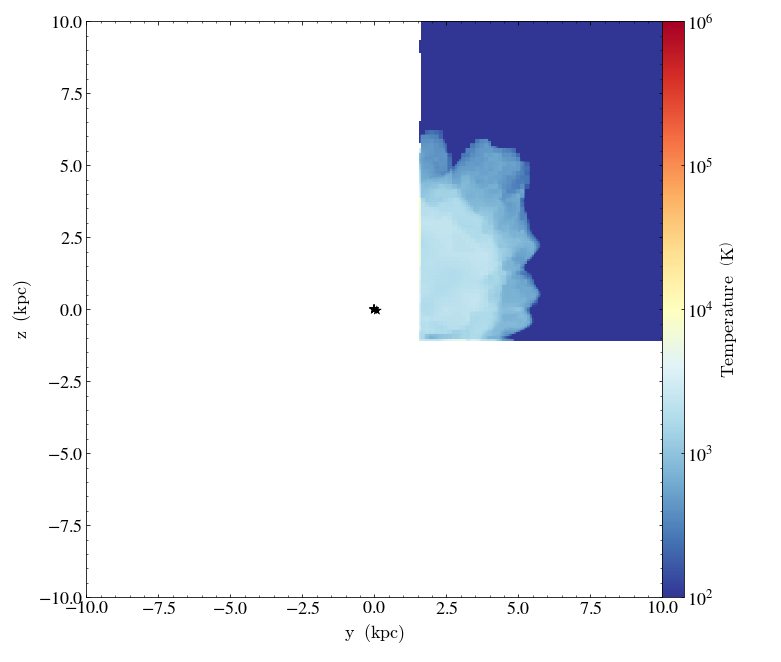
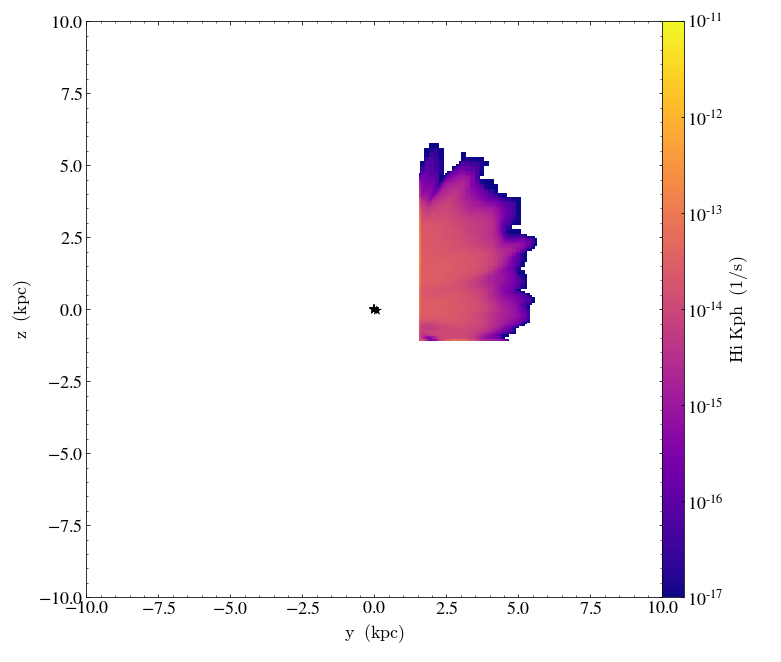
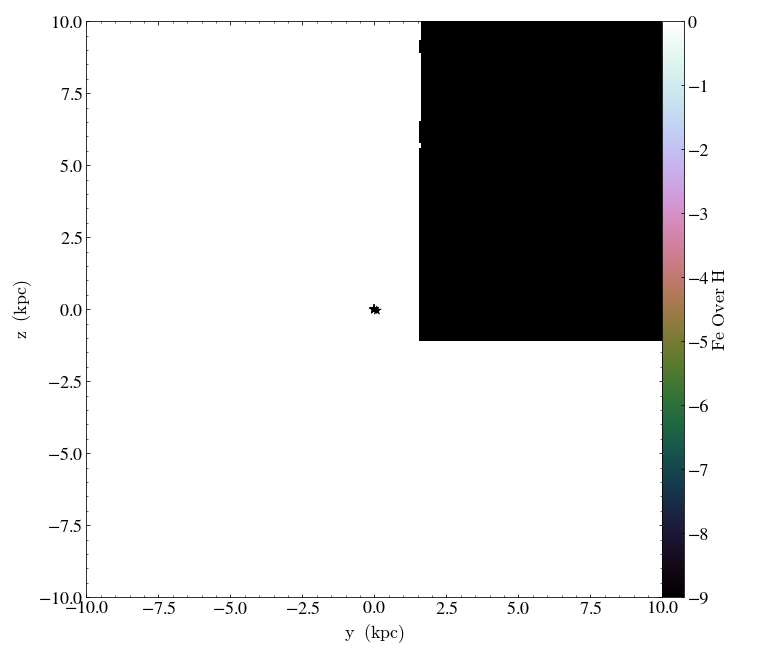
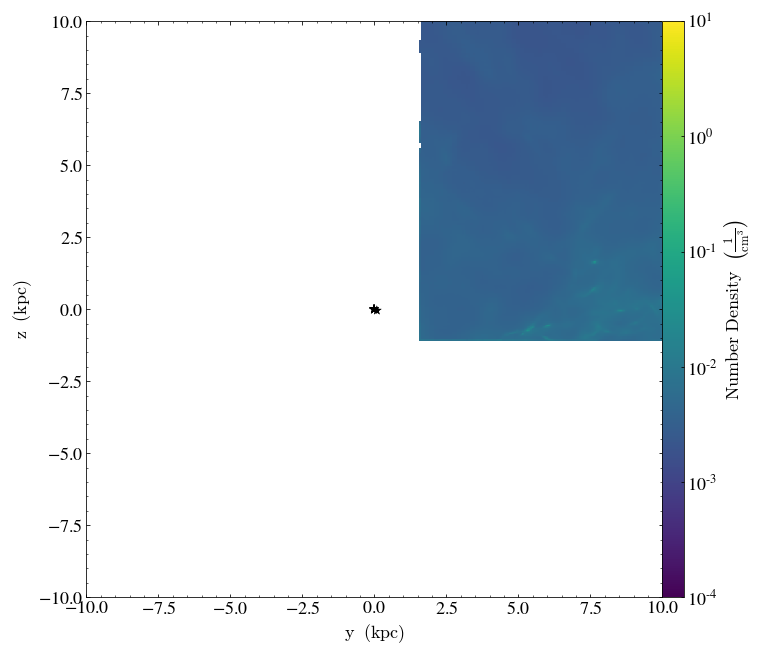
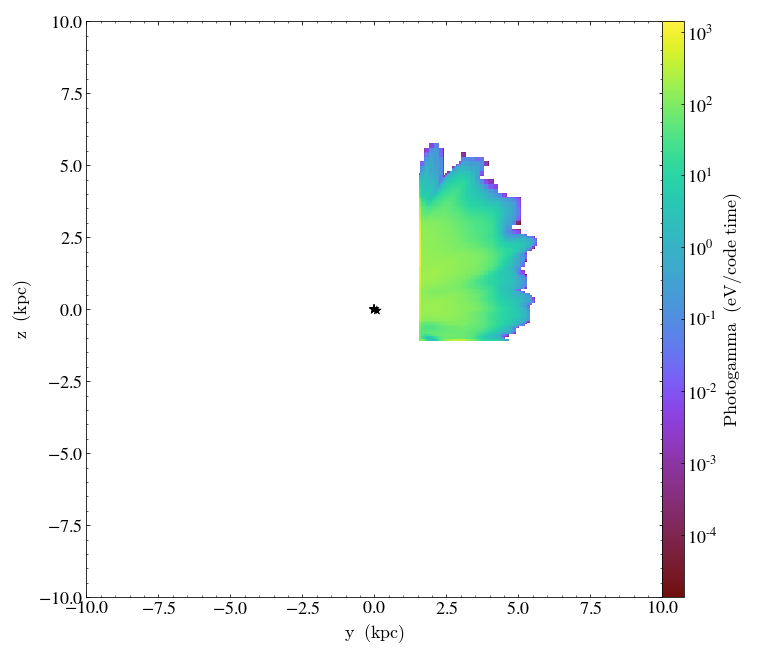

/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


['DD0044_Projection_x_Temperature_Metal_Density.png',
 'DD0044_Projection_x_HI_kph_Metal_Density.png',
 'DD0044_Projection_x_Fe_over_H_Metal_Density.png',
 'DD0044_Projection_x_number_density_Metal_Density.png',
 'DD0044_Projection_x_PhotoGamma_Metal_Density.png']

In [17]:
fields = ['number_density','Temperature','Fe_over_H','HI_kph','PhotoGamma']
center = ds.domain_center.to('kpc')
l      = 10.0 * yt.units.kpc
region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(ds, 'x', fields, weight_field = 'Metal_Density', center = 'max',
                       data_source=region, width = 2.0*l)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E6)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix') 
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
    
pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)

pp.show()
pp.save()

In [52]:
fig, all_axes, colorbars = get_multi_plot(4, 1, colorbar='horizontal', bw = 4)
fields = ['number_density','Temperature','HI_kph',
          'Fe_over_H'] # ,'Ba_over_H']

width = 2.0 * l

axes = all_axes[0]

center = ds.domain_center.to('kpc')
l      = 10.0 * yt.units.kpc
region = ds.region(center, center - l, center + l)

#region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(ds, 'y', fields, weight_field = 'Metal_Density', center = center,
                       data_source=region, 
                       width = 2.0*l)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E5)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix') 
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
    
pp.set_buff_size(512)

pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)
#pp = yt.ProjectionPlot(ds, 'y', fields, weight_field = 'Metal_Density', center = center,
#                       data_source=region)#, width = 2.0*l)









proj_frb = pp.data_source.to_frb((20,'kpc'), 512)

axes[1].yaxis.set_visible(False)
axes[2].yaxis.set_visible(False)
axes[3].yaxis.set_visible(False)


frb1 = np.array(proj_frb['number_density'])
frb2 = np.array(proj_frb['Temperature'])
frb3 = np.array(proj_frb['HI_kph'].to('1/s'))
frb4 = np.array(proj_frb['Fe_over_H'])
    
plots = [ axes[0].imshow( frb1, origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[1].imshow( frb2 ,origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[2].imshow( frb3 ,origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[3].imshow( frb4 ,origin='lower', extent=[0,20,0,20]) ]

plots[0].set_clim((1.0E-4,1.0E1))
plots[0].set_cmap('viridis')
plots[1].set_clim((1.0E2,1.0E5))
plots[1].set_cmap('RdYlBu_r')
plots[2].set_clim((1.0E-17,1.0E-11))
plots[2].set_cmap('plasma')
plots[3].set_clim((-9,0))
plots[3].set_cmap('cubehelix')


for a in axes:
    #a.set_xticks([0,4,8,12,16])
    #a.set_xlabel('x (kpc)')
    a.set_xticklabels([])


particle_types = ['main_sequence_stars','main_sequence_popIII_stars','remnant_stars','low_mass_unresolved_stars']
particle_colors = ['C1','black','black','black']
particle_markers = ['*','*','D','o']
particle_sizes   = [100,100,10,10]
particle_alpha   = [1,1,0.5,0.5]

for i in np.arange(np.size(particle_types)):
    
    
    scale = ds.domain_width[0].to('kpc').value / width.value
    center2 = center.to('kpc') / ds.domain_width.to('kpc')
    center2 = [0.5]*3
    particle_x = scale*(region[(particle_types[i],'particle_position_x')] - ds.domain_center[0]).value + center2[0] #.to('kpc').value
    particle_y = scale*(region[(particle_types[i],'particle_position_y')] - ds.domain_center[1]).value + center2[1] #to('kpc').value
    particle_z = scale*(region[(particle_types[i],'particle_position_z')] - ds.domain_center[2]).value + center2[2] #to('kpc').value

    for ax in axes:
        ax.scatter(particle_z, particle_x, s=particle_sizes[i],
                   color = particle_colors[i], marker = particle_markers[i],
                   transform = ax.transAxes, alpha = particle_alpha[i])
          
    
titles = [r'$\mathrm{Density}\ (\mathrm{g\ cm^{-3}})$',
          r'$\mathrm{Temperature}\ (\mathrm{K})$',
          r'$\mathrm{HI~Ionization~Rate}\ (\mathrm{s^{-1}})$',
          r'$\mathrm{[Fe/H]}\ (\mathrm{(dex)})$']


axes[0].plot( [0.07 + 0.05, (0.07 + 0.1) + 0.05], [0.05,0.05], color = "white",
          lw = 3, transform = axes[0].transAxes)
xy = (0.07, 0.075)
axes[0].text(xy[0], xy[1], "%.1f kpc"%(width / 10.0), color = 'white',
        fontsize = 16, transform = axes[0].transAxes)

for p, cax, t in zip(plots, colorbars, titles):
    cbar = fig.colorbar(p,cax=cax,orientation='horizontal')
    cbar.set_label(t)
    
fig.savefig("test.png")


/home/aemerick/.local/lib/python3.7/site-packages/yt/data_objects/construction_data_containers.py:379: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(nvals, nwvals[:,None], nvals)


In [136]:
width

20.0 kpc

/home/aemerick/.local/lib/python3.7/site-packages/yt/data_objects/construction_data_containers.py:379: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(nvals, nwvals[:,None], nvals)
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



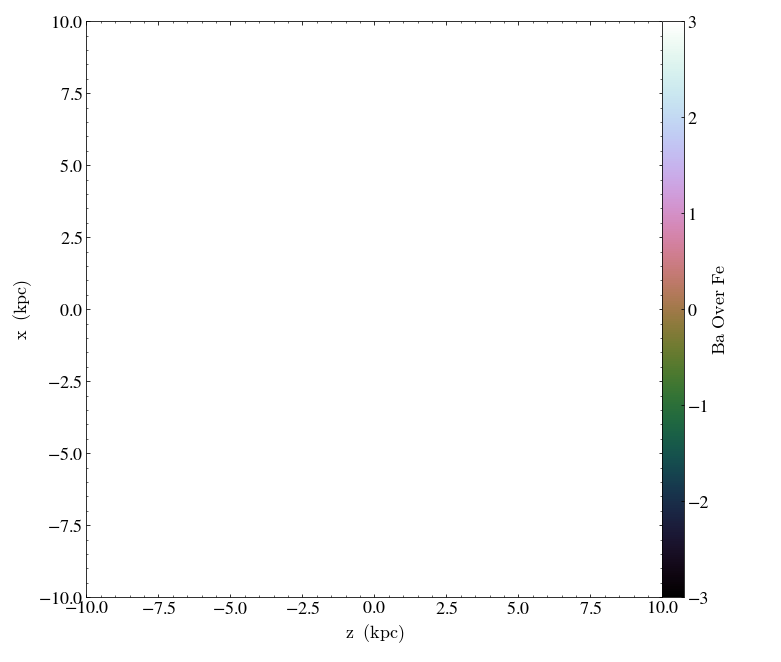
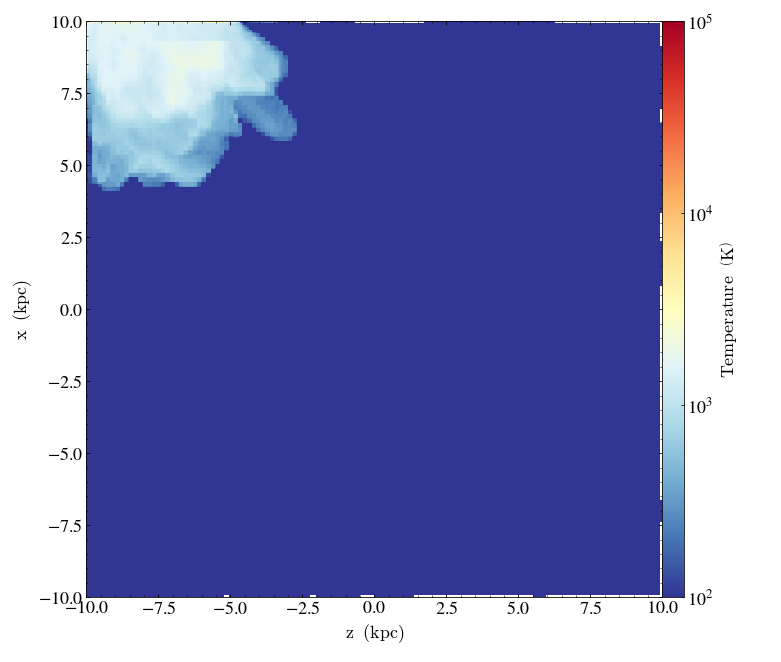
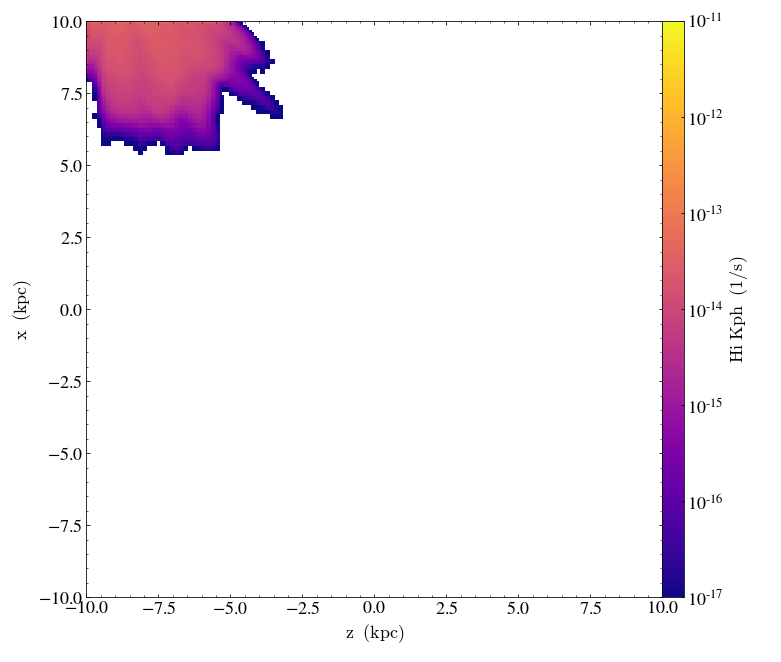
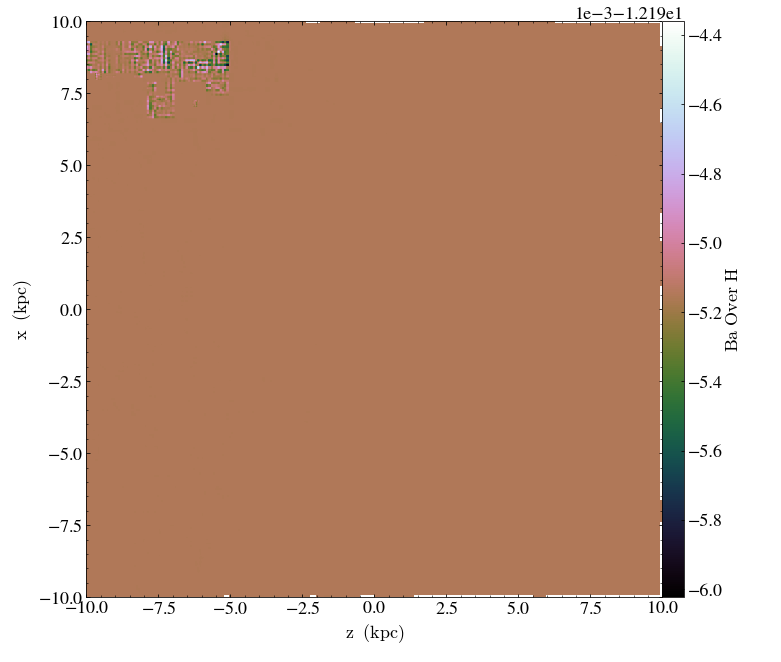
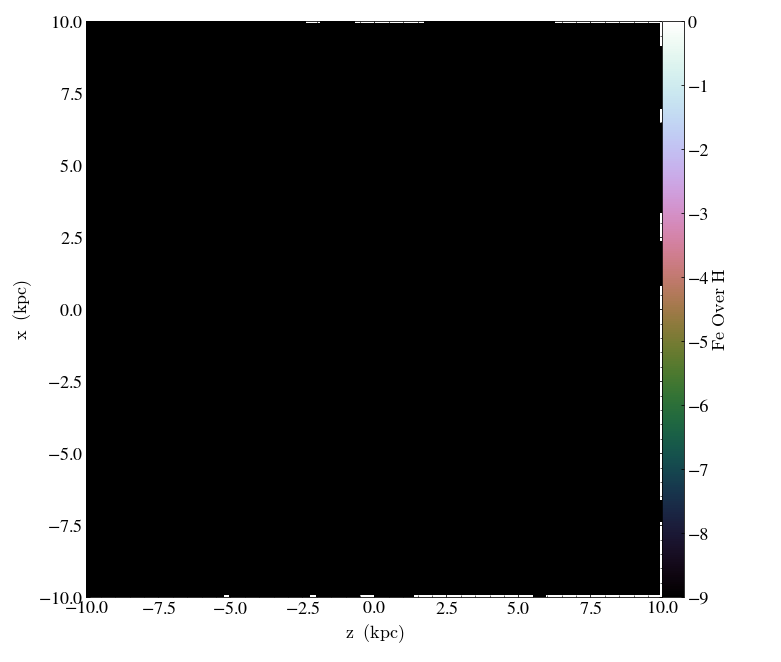
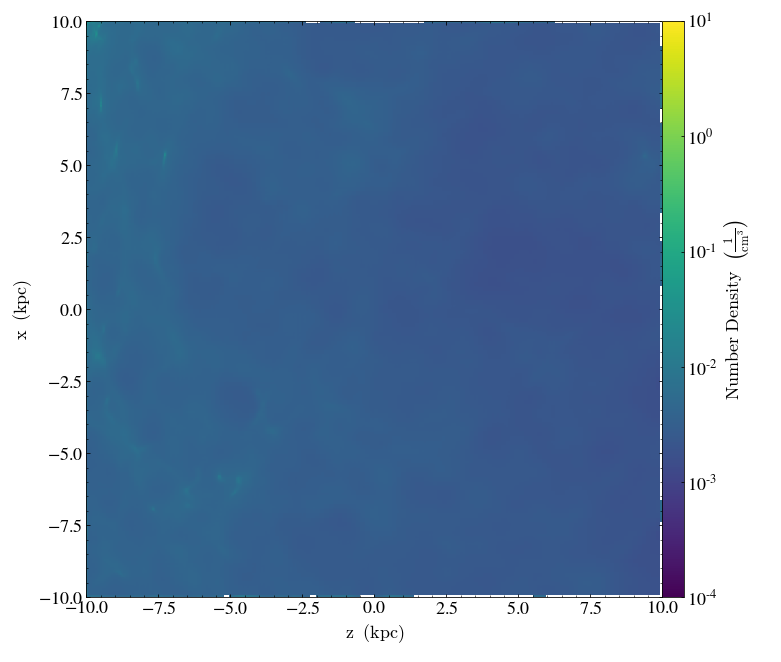

/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/aemerick/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


['DD0044_Projection_y_Ba_over_Fe_Metal_Density.png',
 'DD0044_Projection_y_Temperature_Metal_Density.png',
 'DD0044_Projection_y_HI_kph_Metal_Density.png',
 'DD0044_Projection_y_Ba_over_H_Metal_Density.png',
 'DD0044_Projection_y_Fe_over_H_Metal_Density.png',
 'DD0044_Projection_y_number_density_Metal_Density.png']

In [13]:
fields = ['number_density','Temperature','Fe_over_H','Ba_over_H','Ba_over_Fe','HI_kph']
center = ds.domain_center.to('kpc')
l      = 10.0 * yt.units.kpc
region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(ds, 'y', fields, weight_field = 'Metal_Density', center = center,
                       data_source=region, width = 2.0*l)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E5)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix')
    

            
if 'Ba_over_H' in pp.fields:
    field = 'Ba_over_H'
    pp.set_log(field,False)
    #pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix') 
    
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
    
pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)




pp.show()

pp.save()

In [ ]:
fields = ['number_density','Temperature','Fe_over_H',"alpha_over_Fe",'HI_kph']

region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(ds, 'z', fields, weight_field = 'Metal_Density', center = center,
                       data_source=region, width = 2.0*l)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E5)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix') 
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
    
pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)

pp.show()
pp.save()

In [87]:
print(np.unique(pt))

select_WD_sources = (bm > 3.0) * (bm < 8.0) * (pt < 15)
select_WD = (pt == 12)
print(np.size(bm[select_WD_sources]))
print(np.size(bm[select_WD]))
death = data[('io','dynamical_time')].to('Myr') + data['creation_time'].to('Myr')

print(death[select_WD])

[ 1. 11. 12. 13. 14. 15.] dimensionless
137
33
[1.40846669e+07 1.40846669e+07 8.59511698e+03 1.40846671e+07
 1.40846676e+07 1.40846677e+07 1.40846694e+07 1.37429163e+03
 1.40846723e+07 1.40846728e+07 1.40846106e+07 1.40846108e+07
 1.40846109e+07 1.40846111e+07 1.40846112e+07 1.40846113e+07
 1.40846113e+07 1.40846120e+07 1.40846120e+07 1.40846122e+07
 1.40846125e+07 1.40846104e+07 1.40846108e+07 1.40846109e+07
 1.40846110e+07 1.40846111e+07 1.40846113e+07 1.40846115e+07
 1.40846115e+07 1.40846117e+07 1.40846120e+07 1.40846122e+07
 1.40846122e+07] Myr


In [57]:
np.min((data['particle_mass'][pt<11]).to('Msun'))

1843.8877335388886 Msun

In [56]:
import matplotlib.colors as colors

def generate_2d_color_hist(data, xfield, yfield, zfield = 'cell_mass',
                           method = 'sum', # method for color field. Sum values, min / max, etc.
                           db = 0.1, selection = None,
                           xlim=None, ylim=None, xlog=False, ylog=False,
                           xunit = None, yunit = None, zunit = None):
    
    #xfield = xe1 + '_over_' + xe2
    #yfield = ye1 + '_over_' + ye2
        
    xvals = data[xfield]
    yvals = data[yfield]
    zvals = data[zfield]
    
    if not (selection is None):
        xvals = xvals[selection]
        yvals = yvals[selection]
        zvals = zvals[selection]
    
    
    
    if xlog:
        xvals = np.log10(xvals)
    if ylog:
        yvals = np.log10(yvals)
    
    if not (xunit is None):
        xvals = xvals.to(xunit)
    if not (yunit is None):
        yvals = yvals.to(yunit)
    if not (zunit is None):
        zvals = zvals.to(zunit)
    
    if xlim is None:
        xlim = [np.min(xvals), np.max(xvals)]
    if ylim is None:
        ylim = [np.min(yvals), np.max(yvals)]
        
    
    if len(db) > 1:
        dbx = db[0]
        dby = db[1]
    else:
        dbx = db
        dby = db
    
    xbins = np.arange(xlim[0], xlim[1], dbx)
    ybins = np.arange(ylim[0], ylim[1], dby)
    
    
    bin_values,_,__ = np.histogram2d(xvals,yvals,bins=(xbins, ybins), weights = zvals)
    X, Y = np.meshgrid(xbins, ybins)
    
    
    return X, Y, bin_values





In [6]:
dsname2 = "DD0116/DD0116"

ds2 = yt.load(dsname2)
fg.generate_derived_fields(ds2)
ds2 = yt.load(dsname2)
fg.generate_particle_filters(ds2)
data2 = ds2.all_data()

Parsing Hierarchy : 100%|██████████| 1762/1762 [00:00<00:00, 8056.02it/s]
/home/aemerick/code/onezone/onezone/data_tables.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  c == flag or id == flag:
/home/aemerick/.local/lib/python3.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


tracer species present:  ['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
16 mass fields defined
16 mass fraction fields defined
15 number density fields defined
141 abundance ratio fields defined
5 additional helper fields defined


Parsing Hierarchy : 100%|██████████| 1762/1762 [00:00<00:00, 16774.89it/s]


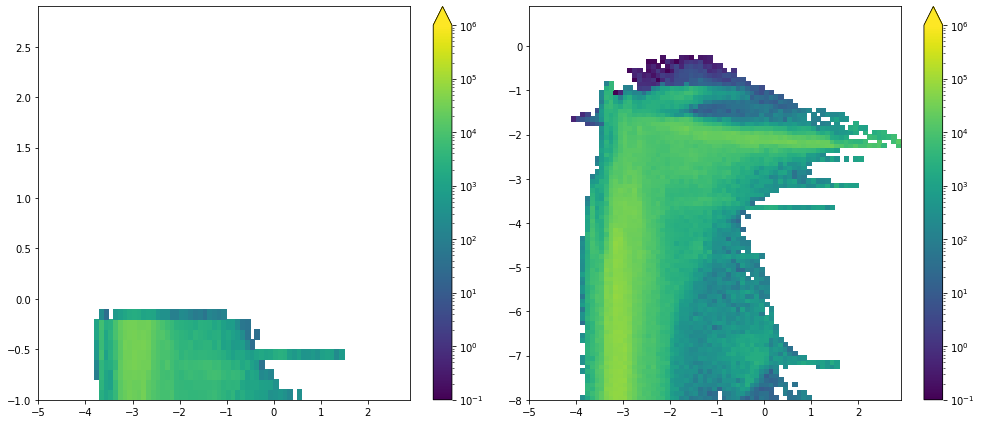

In [9]:
xe1, xe2 = "Fe","H"
ye1, ye2 = "Mg", "Fe"

xlim = [-8,1]
ylim = [-8,1]

ylim = [-1,3]

db = [0.1,0.1]

xlim = [-5,3]

X,Y,vals = generate_2d_color_hist(data2, "number_density", "Ba_over_Fe", "cell_mass", db = db,
                                  selection = (data2['Fe_over_H'] > -4),
                                  xlim=xlim,ylim=ylim, xlog=True, ylog=False, zunit="Msun")


fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,6)

pcm = ax[0].pcolormesh(X, Y, vals.T,   cmap = 'viridis', 
              norm = colors.LogNorm(vmin=0.1,vmax=1.0E6))
fig.colorbar(pcm, ax=ax[0], extend='max')
              
    
    
xlim = [-5,3]   
ylim = [-8,1]
    
X,Y,vals = generate_2d_color_hist(data2, "number_density", "Fe_over_H","cell_mass", db = db,
                                  xlim=xlim,ylim=ylim, xlog=True, ylog=False, zunit="Msun")
pcm = ax[1].pcolormesh(X, Y, vals.T,   cmap = 'viridis', 
              norm = colors.LogNorm(vmin=0.1,vmax=1.0E6))
fig.colorbar(pcm, ax=ax[1], extend='max')



plt.tight_layout()

In [137]:
[x for x in ds.derived_field_list if 'snii' in x[1]]

[]

In [138]:
[x for x in ds.parameters if 'AGB' in x]

['IndividualStarAGBThreshold',
 'IndividualStarTrackAGBMetalDensity',
 'IndividualStarAGBWindVelocity']

In [139]:
ds.field_list

[('all', 'birth_mass'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_type'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('all', 'sn_mass_ejected'),
 ('all', 'wind_mass_ejected'),
 ('enzo', 'AGB_Metal_Density'),
 ('enzo', 'As_Density'),
 ('enzo', 'Ba_Density'),
 ('enzo', 'C_Density'),
 ('enzo', 'Ca_Density'),
 ('enzo', 'Dark_Matter_Density'),
 ('enzo', 'Density'),
 ('enzo', 'Electron_Density'),
 ('enzo', 'FUV_FluxDensity'),
 ('enzo', 'Fe_Density'),
 ('enzo', 'GasEnergy'),
 ('enzo', 'H2II_Density'),
 ('enzo', 'H2II_kdiss'),
 ('enzo', 'H2I_Density'),
 ('enzo', 'H2I_kdiss'),
 ('enzo', 'HII_Density'),
 ('enzo', 'HI_Density'),
 ('enzo', 'HI_kph'),
 ('enzo', 'HM_Density'),
 ('enzo', 'HM_kph'),
 ('enzo', 'HeIII_Density'),
 (

In [4]:
np.max(data2['AGB_Mass_Fraction'][data['cell+mass']]

9.429025495753003e-05 dimensionless

In [7]:
popII = data2['birth_mass'][ (data2['particle_type']>=11)*(data2['metallicity_fraction']>ds2.parameters["PopIIIMetalCriticalFraction"]) ]

In [8]:
print(np.size(popII))
print(np.sum(popII)/(1.0*np.size(popII)))

14044
35.832901889278745 dimensionless


-----------  1 Nodes ----------
Wall time per simulation  6.880E+03   hours
Wall time per simulation  286.66794   days 
Total SU per node         6880.031
Total SU                  6880.031
--------------------------------
-----------  2 Nodes ----------
Wall time per simulation  5.870E+03   hours
Wall time per simulation  244.59279   days 
Total SU per node         5870.227
Total SU                  11740.454
--------------------------------
-----------  3 Nodes ----------
Wall time per simulation  4.822E+03   hours
Wall time per simulation  200.92017   days 
Total SU per node         4822.084
Total SU                  14466.253
--------------------------------
-----------  4 Nodes ----------
Wall time per simulation  3.909E+03   hours
Wall time per simulation  162.85579   days 
Total SU per node         3908.539
Total SU                  15634.156
--------------------------------
-----------  6 Nodes ----------
Wall time per simulation  3.513E+03   hours
Wall time per simulation  146

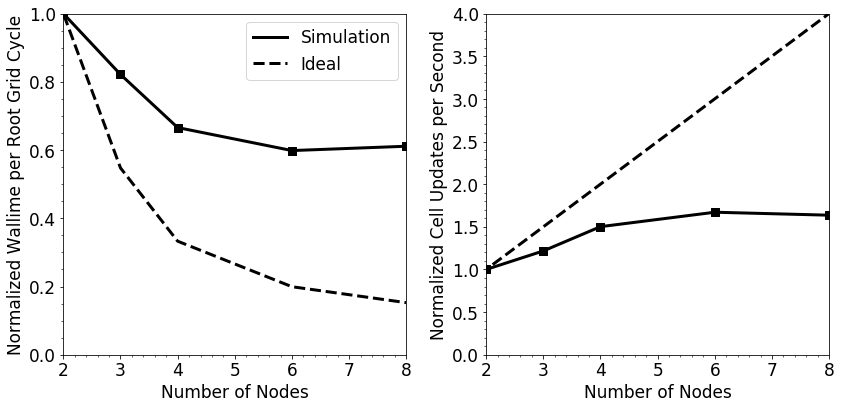

In [230]:
#
#
# Scaling
#

rc('text',usetex=False)
rc('font',size=fsize)

#
cpu_per_node = 48.0
ps = 60

Myr     = 3.1536e+13
tu      = 4.6206558786941e+14
dt_root = (2.059915e-02 * tu) / Myr

tfinal  = 750.0                     # Myr

wall_per_dt_root = {1: 0, 2: 0, 4: 3518.257, 6: 0, 8: 0, 16: 0}         # seconds

wall_per_dt_root = {1: 1.0629E4, 2:   8662.977, 3: 7086.67, 4: 5662.4    , 6:      5083.11, 8: 5090.81   , 12: 4935.414  , 16: 4847.11   , 32:   5499.361}         # seconds
cell_updates     = {1: 3.319E8, 2: 3.170720E8, 3 : 3.157659e+08, 4: 3.112671E8, 6: 3.108882e+08, 8: 3.048946E8, 12: 3.053436E8, 16: 3.048714E8, 32: 2.975159E8}
updates_s_proc   = {1: 650.6, 2: 3.812585E2, 3: 309.42, 4: 286.3057  , 6: 2.123646e+02, 8: 155.966   , 12: 107.409   , 16: 81.89     , 32: 35.2      }

norm_wall_per_dt_root = {}

for node in wall_per_dt_root.keys():
    
    if wall_per_dt_root[node] == 0.0:
        norm_wall_per_dt_root[node] = 0.0
        continue
        
    

    wall_per_sim = (tfinal / dt_root) * wall_per_dt_root[node]
    
    
    norm_wall_per_dt_root[node] = cell_updates[4] / (updates_s_proc[node]*node*cpu_per_node)
    
    wall_per_sim = (tfinal / dt_root) * norm_wall_per_dt_root[node]


    print("----------- %2i Nodes ----------"%(node))
    print("Wall time per simulation  %5.3E   hours"%(wall_per_sim / 3600.0))
    print("Wall time per simulation  %5.5f   days "%(wall_per_sim / 3600.0 / 24.0))

    print("Total SU per node         %5.3f"%(wall_per_sim / 3600.0))
    print("Total SU                  %5.3f"%(wall_per_sim / 3600.0 * node))
    
    print("--------------------------------")
    
    
    
#print("Total SU on 4  nodes  (192 core) %5.3f"%(wall_per_sim / 3600.0))
#print("Total SU on 8  nodes  (384 core) %5.3f"%(wall_per_sim / 3600.0))
#print("Total SU on 16 nodes  ( core) %5.3f"%(wall_per_sim / 3600.0))



fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

x = np.array([*norm_wall_per_dt_root.keys()]) #* cpu_per_node
y = np.array([*norm_wall_per_dt_root.values()])

inorm = 1

ax[0].plot(  x, y / y[inorm], color= 'black',lw=3, ls='-', label = "Simulation")
ax[0].scatter(  x, y / y[inorm], s = ps, color = 'black',marker = 's')

ax[0].plot(  x, y / y[inorm] * 1.0/(x/x[inorm]),color='black',ls='--',lw=3, label= "Ideal")
        

x = np.array([*updates_s_proc.keys()])   #* cpu_per_node
y = np.array([*updates_s_proc.values()]) * x

ax[1].plot(     x, y / y[inorm], color= 'black', ls = '-',lw=3)
ax[1].scatter(  x, y / y[inorm], s = ps, color = 'black',marker = 's')

ax[1].plot(  x, (x/x[inorm]),color='black',ls='--',lw=3)

ax[0].set_ylim(0.0,1.0)
ax[1].set_ylim(0,4)
#ax[0].semilogx()

for a in ax:
    a.set_xlim(x[inorm],8)
    a.set_xlabel("Number of Nodes")
    a.xaxis.set_minor_locator(AutoMinorLocator())
    a.yaxis.set_minor_locator(AutoMinorLocator())
    



ax[0].set_ylabel("Normalized Wallime per Root Grid Cycle")
ax[1].set_ylabel("Normalized Cell Updates per Second")

ax[0].legend(loc='best')

plt.tight_layout()

fig.savefig("strong_scaling.png")

0.3018188214852916

In [45]:
-x + x[1] + y[1]/y[1]

array([  2.,   1.,  -1.,  -3.,  -5.,  -9., -13., -29.])

In [ ]:
x  = wall_per_dt_root.keys

In [18]:
np.asarray(x)

array(dict_keys([1, 2, 4, 6, 8, 12, 16, 32]), dtype=object)

In [ ]:
#
#
# Scaling
#
#
Myr     = 3.1536e+13
tu      = 4.6206558786941e+14
dt_root_nop = (2.059915e-02 * tu) / Myr

tfinal  = 750.0                     # Myr



# NO PHOTONS
wall_per_dt_root_nop = {1: 0, 2: 0, 4: 697.0759, 6:0, 8: 0, 12:0,16: 0,32:0}         # seconds
cell_updates_nop     = {1:0, 2:0, 4:4.056438E8, 6:0, 8:0, 12:0, 16:0, 32:0}
updates_s_proc_nop   = {1:0, 2:0, 4:3.030843E3, 6:0, 8:0, 12:0, 16:0, 32:0}

for node in wall_per_dt_root_nop.keys():
    
    if wall_per_dt_root_nop[node] == 0.0:
        continue

    wall_per_sim_nop = (tfinal / dt_root_nop) * wall_per_dt_root_nop[node]


    print("----------- %2i Nodes ----------"%(node))
    print("Wall time per simulation  %5.3E   hours"%(wall_per_sim_nop / 3600.0))
    print("Wall time per simulation  %5.5f   days "%(wall_per_sim_nop / 3600.0 / 24.0))

    print("Total SU per node         %5.3f"%(wall_per_sim_nop / 3600.0))
    print("Total SU                  %5.3f"%(wall_per_sim_nop / 3600.0 * node))
    
    print("--------------------------------")
    
    
    
#print("Total SU on 4  nodes  (192 core) %5.3f"%(wall_per_sim / 3600.0))
#print("Total SU on 8  nodes  (384 core) %5.3f"%(wall_per_sim / 3600.0))
#print("Total SU on 16 nodes  ( core) %5.3f"%(wall_per_sim / 3600.0))



In [19]:
size = 64.0

baryon_fields   = 51
particle_fields = 15 + 15


Ncell = 1.0E8
Ndm   = 256**3
Nstar = 3.0E5


mem = size * (  baryon_fields*Ncell + particle_fields*(Ndm + Nstar))

Nout = 170

print("Total memory per data dump  %5.3f GB"%(mem / 8.0 / 1.0E9))
print("Total memory per simulation %5.3f TB"%(mem / 8.0 / 1.0E12 * Nout))


Total memory per data dump  44.899 GB
Total memory per simulation 7.633 TB


In [20]:
size = 64.0

baryon_fields   = 14+9
particle_fields = 15 + 15


Ncell = 1.0E8
Ndm   = 0
Nstar = 0


mem = size * (  baryon_fields*Ncell + particle_fields*(Ndm + Nstar))

Nout = 170

print("Total memory per data dump  %5.3f GB"%(mem / 8.0 / 1.0E9))
print("Total memory per simulation %5.3f TB"%(mem / 8.0 / 1.0E12 * Nout))


Total memory per data dump  18.400 GB
Total memory per simulation 3.128 TB


In [222]:
#
#
#
#
#
#
#
#
#
test_dsname = "DD0081/DD0081"

test_ds = yt.load(test_dsname)
fg.generate_derived_fields(test_ds)
test_ds = yt.load(test_dsname)
fg.generate_particle_filters(test_ds)
test_data = test_ds.all_data()

fig, all_axes, colorbars = get_multi_plot(4, 1, colorbar='horizontal', bw = 4)
fields = ['number_density','Temperature','HI_kph', 'Pe_heating_rate_masked']
          #'Fe_over_H'] # ,'Ba_over_H'


axes = all_axes[0]

test_center = test_ds.domain_center.to('kpc')
l      = 10.0 * yt.units.kpc
test_region = test_ds.region(test_center, test_center - l, test_center + l)
width = 2.0 * l

#region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(test_ds, 'y', fields, weight_field = 'Metal_Density', center = test_center,
                       data_source=test_region, 
                       width = 2.0*l)
pp2 = yt.ProjectionPlot(test_ds, 'y', 'Pe_heating_rate_masked', weight_field = 'Density', center = test_center,
                       data_source=test_region, 
                       width = 2.0*l)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E5)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'cubehelix') 
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
if 'Pe_heating_rate_masked' in pp2.fields:
    field = 'Pe_heating_rate_masked'
    pp2.set_zlim(field, 1.0E-40,1.0E-30)
    pp2.set_cmap(field, 'plasma')
    
    
pp.set_buff_size(512)

pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)
#pp = yt.ProjectionPlot(ds, 'y', fields, weight_field = 'Metal_Density', center = center,
#                       data_source=region)#, width = 2.0*l)



proj_frb = pp.data_source.to_frb((20,'kpc'), 512)
proj2_frb = pp2.data_source.to_frb((20,'kpc'), 512)

axes[1].yaxis.set_visible(False)
axes[2].yaxis.set_visible(False)
axes[3].yaxis.set_visible(False)


frb1 = np.array(proj_frb['number_density'])
frb2 = np.array(proj_frb['Temperature'])
frb3 = np.array(proj_frb['HI_kph'].to('1/s'))
frb4 = np.array(proj2_frb['Pe_heating_rate_masked'])
#frb4 = np.array(proj_frb['Fe_over_H'])
    
plots = [ axes[0].imshow( frb1, origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[1].imshow( frb2 ,origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[2].imshow( frb3 ,origin='lower',norm=LogNorm(), extent=[0,20,0,20]),
          axes[3].imshow( frb4 ,origin='lower',norm=LogNorm(), extent=[0,20,0,20]) ]

plots[0].set_clim((1.0E-4,1.0E1))
plots[0].set_cmap('viridis')
plots[1].set_clim((1.0E2,1.0E5))
plots[1].set_cmap('RdYlBu_r')
plots[2].set_clim((1.0E-17,1.0E-11))
plots[2].set_cmap('plasma')
plots[3].set_clim((1.0E-40,1.0E-30))
plots[3].set_cmap('plasma')
#plots[3].set_clim((-9,0))
#plots[3].set_cmap('cubehelix')


for a in axes:
    #a.set_xticks([0,4,8,12,16])
    #a.set_xlabel('x (kpc)')
    a.set_xticklabels([])


particle_types = ['main_sequence_stars','main_sequence_popIII_stars','remnant_stars','low_mass_unresolved_stars']
particle_colors = ['C1','black','black','black']
particle_markers = ['*','*','D','o']
particle_sizes   = [25,25,10,10]
particle_alpha   = [1,1,0.5,0.5]

for i in np.arange(np.size(particle_types)):
    
    
    scale = test_ds.domain_width[0].to('kpc').value / width.value
    center2 = test_center.to('kpc') / test_ds.domain_width.to('kpc')
    center2 = [0.5]*3
    particle_x = scale*(test_region[(particle_types[i],'particle_position_x')] - test_ds.domain_center[0]).value + center2[0] #.to('kpc').value
    particle_y = scale*(test_region[(particle_types[i],'particle_position_y')] - test_ds.domain_center[1]).value + center2[1] #to('kpc').value
    particle_z = scale*(test_region[(particle_types[i],'particle_position_z')] - test_ds.domain_center[2]).value + center2[2] #to('kpc').value

    for ax in axes:
        ax.scatter(particle_z, particle_x, s=particle_sizes[i],
                   color = particle_colors[i], marker = particle_markers[i],
                   transform = ax.transAxes, alpha = particle_alpha[i])
          
    
titles = [r'$\mathrm{Number~Density}\ (\mathrm{g\ cm^{-3}})$',
          r'$\mathrm{Temperature}\ (\mathrm{K})$',
          r'$\mathrm{HI~Ionization~Rate}\ (\mathrm{s^{-1}})$',
          r'$\Gamma_{\mathrm{PE}} (\mathrm{erg s^{-1} cm^{-3}})$']
          #r'$\mathrm{[Fe/H]}\ (\mathrm{(dex)})$']


axes[0].plot( [0.07 + 0.05, (0.07 + 0.1) + 0.05], [0.05,0.05], color = "white",
          lw = 3, transform = axes[0].transAxes)
xy = (0.07, 0.075)
axes[0].text(xy[0], xy[1], "%.1f kpc"%(width / 10.0), color = 'white',
        fontsize = 16, transform = axes[0].transAxes)

for p, cax, t in zip(plots, colorbars, titles):
    cbar = fig.colorbar(p,cax=cax,orientation='horizontal')
    cbar.set_label(t)
    
fig.savefig("test_phys.png")





Parsing Hierarchy : 100%|██████████| 1576/1576 [00:00<00:00, 14902.36it/s]


tracer species present:  ['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
16 mass fields defined
16 mass fraction fields defined
15 number density fields defined
141 abundance ratio fields defined
5 additional helper fields defined


Parsing Hierarchy : 100%|██████████| 1576/1576 [00:00<00:00, 15770.92it/s]


In [221]:
#
#
#
#
#
#
#
#
#
test2_dsname = "DD0116/DD0116"

test2_ds = yt.load(test2_dsname)
fg.generate_derived_fields(test2_ds)
test2_ds = yt.load(test2_dsname)
fg.generate_particle_filters(test2_ds)
test2_data = test2_ds.all_data()

fig, all_axes, colorbars = get_multi_plot(4, 1, colorbar='horizontal', bw = 4)
#fields = ['number_density','Temperature','HI_kph', 'Pe_heating_rate_masked']
          #'Fe_over_H'] # ,'Ba_over_H'
    
fields = ['number_density','O_over_H','Fe_over_H','Ba_over_H']


axes = all_axes[0]

scale_factor = 1.0 / ((1.0+test2_ds.current_redshift)/(1.0+test_ds.current_redshift))

test2_center = test2_ds.domain_center.to('kpc')
l2      = 10.0 * yt.units.kpc * scale_factor
test2_region = test2_ds.region(test2_center, test2_center - l2, test2_center + l2)
width2 = 2.0 * l2

image_l = width2.value

#region = ds.region(center, center - l, center + l)

pp = yt.ProjectionPlot(test2_ds, 'y', fields, weight_field = 'Metal_Density', center = test2_center,
                       data_source=test2_region, 
                       width = width2)


if 'number_density' in pp.fields:
    field = 'number_density'
    pp.set_zlim(field, 1.0E-4, 1.0E1)
    pp.set_cmap(field,'viridis')
    pp.set_log(field,True)
    
if 'Temperature' in pp.fields:
    field = 'Temperature'
    pp.set_zlim(field, 100.0, 1.0E5)
    pp.set_cmap(field,'RdYlBu_r')  
    pp.set_log(field,True)
        
if 'Fe_over_H' in pp.fields:
    field = 'Fe_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -4, 0)
    pp.set_cmap(field,'Greens') 
    
if 'O_over_H' in pp.fields:
    field = 'O_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -9, 0)
    pp.set_cmap(field,'Reds') 
    
if 'Ba_over_H' in pp.fields:
    field = 'Ba_over_H'
    pp.set_log(field,False)
    pp.set_zlim(field, -4.2,-3.78)
    pp.set_cmap(field,'Blues')  
#if 'Ba_over_H' in pp2.fields:
#    field = 'Ba_over_H'
#    pp2.set_log(field,False)
#    pp2.set_zlim(field, -4,0)
#    pp2.set_cmap(field,'Blues')      
    
if 'alpha_over_Fe' in pp.fields:
    field = 'alpha_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -2, 2)
    pp.set_cmap(field,'PRGn') 

if 'Ba_over_Fe' in pp.fields:
    field = 'Ba_over_Fe'
    pp.set_log(field,False)
    pp.set_zlim(field, -3, 3)
    pp.set_cmap(field,'cubehelix')

if 'HI_kph' in pp.fields:
    field = 'HI_kph'
    pp.set_unit(field,'1/s')
    pp.set_zlim(field, 1.0E-17, 1.0E-11)
    pp.set_cmap(field,'plasma')
    
if 'Pe_heating_rate_masked' in pp.fields:
    field = 'Pe_heating_rate_masked'
    pp.set_zlim(field, 1.0E-40,1.0E-30)
    pp.set_cmap(field, 'plasma')
    
    
pp.set_buff_size(512)

pp.annotate_particles(0.95, ptype = 'main_sequence_stars', marker='*', col='C1', p_size=100)
pp.annotate_particles(0.95, ptype = 'main_sequence_popIII_stars', marker='*', col='black', p_size=100)
pp.annotate_particles(0.95, ptype = 'remnant_stars', marker='D', col='black', p_size = 10)
pp.annotate_particles(0.95, ptype = 'low_mass_unresolved_stars', marker='o', col = 'black', p_size=10)
#pp = yt.ProjectionPlot(ds, 'y', fields, weight_field = 'Metal_Density', center = center,
#                       data_source=region)#, width = 2.0*l)



proj_frb = pp.data_source.to_frb(( image_l,'kpc'), 512)
#proj2_frb = pp2.data_source.to_frb(( image_l,'kpc'), 512)


axes[1].yaxis.set_visible(False)
axes[2].yaxis.set_visible(False)
axes[3].yaxis.set_visible(False)


frb1 = np.array(proj_frb['number_density'])
frb2 = np.array(proj_frb['O_over_H'])
frb3 = np.array(proj_frb['Fe_over_H'])
#frb4 = np.array(proj2_frb['Ba_over_H'])
frb4 = np.array(proj_frb['Ba_over_H'])

#frb4 = np.array(proj_frb['Fe_over_H'])
    
plots = [ axes[0].imshow( frb1, origin='lower',norm=LogNorm(), extent=[0,image_l,0,image_l]),
          axes[1].imshow( frb2 ,origin='lower', extent=[0,image_l,0,image_l]),
          axes[2].imshow( frb3 ,origin='lower', extent=[0,image_l,0,image_l]),
          axes[3].imshow( frb4 ,origin='lower', extent=[0,image_l,0,image_l]) ]

plots[0].set_clim((1.0E-4,1.0E1))
plots[0].set_cmap('viridis')
plots[1].set_clim((-9,0))
plots[1].set_cmap('Reds')
plots[2].set_clim((-9,0))
plots[2].set_cmap('Greens')
plots[3].set_clim((-4.2,-3.78))
plots[3].set_cmap('Blues')
#plots[3].set_clim((-9,0))
#plots[3].set_cmap('cubehelix')


for a in axes:
    #a.set_xticks([0,4,8,12,16])
    #a.set_xlabel('x (kpc)')
    a.set_xticklabels([])


particle_types = ['main_sequence_stars','main_sequence_popIII_stars','remnant_stars','low_mass_unresolved_stars']
particle_colors = ['C1','black','black','black']
particle_markers = ['*','*','D','o']
particle_sizes   = [25,25,10,10]
particle_alpha   = [1,1,0.5,0.5]

for i in np.arange(np.size(particle_types)-1,-1,-1):
    
    
    scale = test2_ds.domain_width[0].to('kpc').value / width2.value
    center3 = test_center.to('kpc') / test2_ds.domain_width.to('kpc')
    center3 = [0.5]*3
    particle_x = scale*(test2_region[(particle_types[i],'particle_position_x')] - test2_ds.domain_center[0]).value + center3[0] #.to('kpc').value
    particle_y = scale*(test2_region[(particle_types[i],'particle_position_y')] - test2_ds.domain_center[1]).value + center3[1] #to('kpc').value
    particle_z = scale*(test2_region[(particle_types[i],'particle_position_z')] - test2_ds.domain_center[2]).value + center3[2] #to('kpc').value

    for ax in [axes[0]]:
        ax.scatter(particle_z, particle_x, s=particle_sizes[i],
                   color = particle_colors[i], marker = particle_markers[i],
                   transform = ax.transAxes, alpha = particle_alpha[i])
          
titles = [r'$\mathrm{Number~Density}\ (\mathrm{g\ cm^{-3}})$',
          r'$\mathrm{[O/H]}\ (\mathrm{dex})$',
          r'$\mathrm{[Fe/H]}\ (\mathrm{dex})$',
          r'$\mathrm{[Ba/H]}\ (\mathrm{dex})$']
          


axes[0].plot( [0.07 + 0.05, (0.07 + 0.1) + 0.05], [0.05,0.05], color = "white",
          lw = 3, transform = axes[0].transAxes)
xy = (0.07, 0.075)
axes[0].text(xy[0], xy[1], "%.1f kpc"%(width2 / 10.0), color = 'white',
        fontsize = 16, transform = axes[0].transAxes)

for p, cax, t in zip(plots, colorbars, titles):
    cbar = fig.colorbar(p,cax=cax,orientation='horizontal')
    cbar.set_label(t)
    
fig.savefig("test_phys2.png")


Parsing Hierarchy : 100%|██████████| 1762/1762 [00:00<00:00, 17924.07it/s]


tracer species present:  ['C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
16 mass fields defined
16 mass fraction fields defined
15 number density fields defined
141 abundance ratio fields defined
5 additional helper fields defined


Parsing Hierarchy : 100%|██████████| 1762/1762 [00:00<00:00, 2533.40it/s]


In [206]:
np.arange(np.size(particle_types)-1,-1,-1)

array([3, 2, 1, 0])

In [223]:
test2_ds.current_redshift

7.4511468536779

/home/aemerick/.local/lib/python3.7/site-packages/yt/data_objects/construction_data_containers.py:379: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(nvals, nwvals[:,None], nvals)



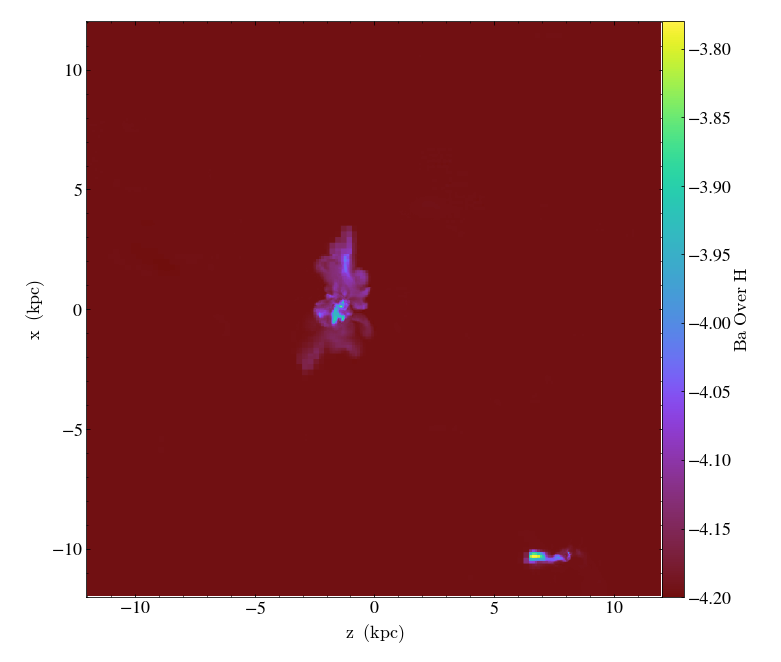

In [219]:
x = yt.ProjectionPlot(test2_ds, 'y', 'Ba_over_H',weight_field="Metal_Density",
                      data_source=test2_region, width = width2)
x.set_zlim('Ba_over_H',-4.2,-3.78)

x.show()

In [199]:
scale_factor

0.831381508702038

In [227]:
(ds.time_unit * 0.4423105).to('Myr')

9.500511107053736 Myr

In [228]:
(5.0 * yt.units.Myr).to('s').value / ds.time_unit.to('s').value

0.23278247612994357